# Preprocessing EEG Data
Here we will import the data and remove artifacts. Artifacts will be removed using notch and bandpass filters, as well as with independent components analysis (ICA).

Preprocessing is done separately for each participant, so the code has to be customized at various stages for the individual data file.

In [1]:
#Import packages
import mne
import numpy as np
from time import time
from mne.preprocessing import ICA
import pickle
from matplotlib import pyplot as plt

In [2]:
#Read in raw EEG data from server
data_path = '/Volumes/experiments/abe/FR_EEG/No_Detection/EEG_data/ABE_FR_nodetect_1.bdf' #must change subject number
excl = ["EXG1","EXG2","EXG3","EXG4", "EXG5", "EXG6", "EXG7", "EXG8"] #Specify VEOG channels for exclusion
raw = mne.io.read_raw_bdf(data_path, preload=True) #load data
raw.drop_channels(excl) #remove VEOG channels

Extracting EDF parameters from /Volumes/experiments/abe/FR_EEG/No_Detection/EEG_data/ABE_FR_nodetect_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2359807  =      0.000 ...  4608.998 secs...


<RawEDF | ABE_FR_nodetect_1.bdf, 65 x 2359808 (4609.0 s), ~1.14 GB, data loaded>

In [3]:
#Apply notch filter to remove electrical noise
raw.notch_filter(np.arange(60, 241, 60), filter_length='auto', phase='zero')

#Apply bandpass filter
raw.filter(1, 100, fir_design='firwin')

#Resample and set common average reference
raw.resample(512, npad='auto')
raw.set_eeg_reference(ref_channels='average')
raw.set_montage('biosemi64')

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Trigger channel has a non-zero initial value of 65536 (

<RawEDF | ABE_FR_nodetect_1.bdf, 65 x 2359808 (4609.0 s), ~1.14 GB, data loaded>

Now that the data are uploaded and filtered we need to manually inspect it to a) make sure it is of sufficient quality for inclusion and b) identify any problematic electrodes for interpolation.

Using matplotlib as 2D backend.


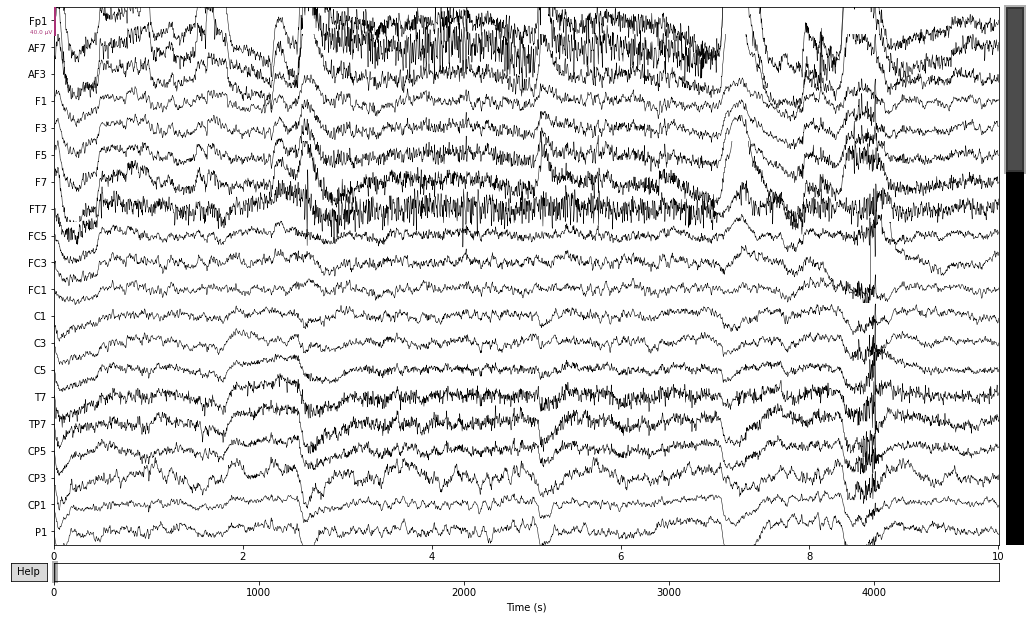

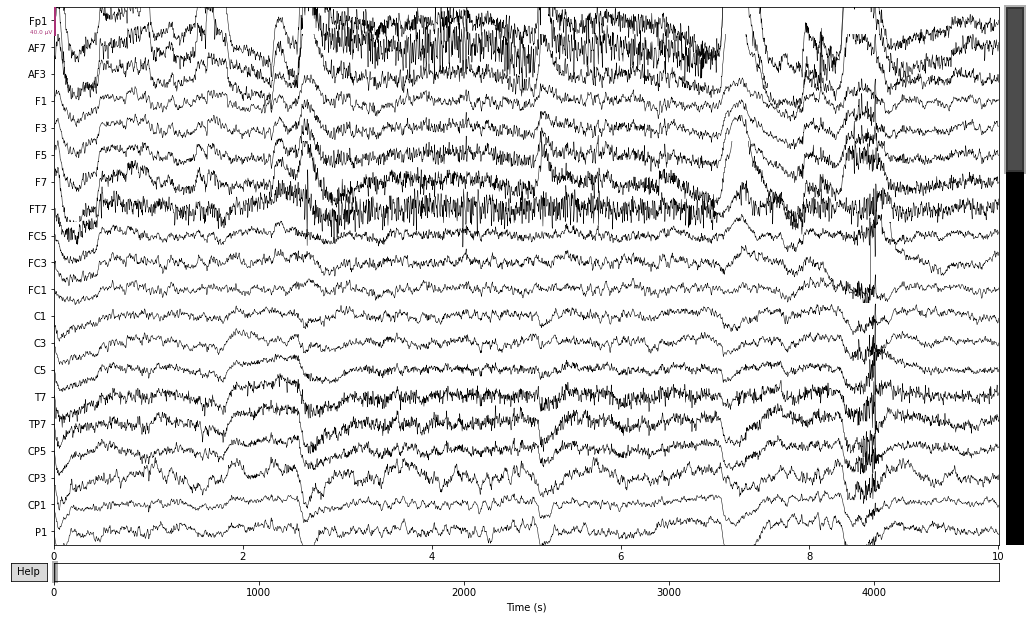

In [4]:
raw.plot()

The data quality is not great- I've identified four electrodes that display erratic activity throughout the experiment and selected them for interpolation.

In [4]:
##STOP!!! Look at data and determine bad chans
raw.info['bads'] = ['FC6', 'FT8', 'Iz', 'F5']
raw.interpolate_bads(reset_bads=True, mode='accurate', origin='auto')

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 4 sensors


<RawEDF | ABE_FR_nodetect_1.bdf, 65 x 2359808 (4609.0 s), ~1.14 GB, data loaded>

## ICA artifact detection
We will now use independent components analysis (ICA) to identify and remove any unwanted artifacts. This involves a delicate balance between removing artifact and preserving brain activity. MNE will identify some components as artifact automatically using its detect_artifacts function, but this usually does not identify eye blinks. The components must be manually inspected and selected for rejection for each participant.

In [ ]:
picks = mne.pick_types(raw.info, eeg=True, eog=False, stim=False)
ica = ICA(n_components=40, method="picard", random_state=0)
reject = dict(mag=5e-12, grad=4000e-13)
ica.fit(raw, picks=picks, reject=reject)
ica.detect_artifacts(raw)
ica.plot_components()

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 40 components


We're looking for EOG and EMG artifacts here, and components 0-11 are our primary suspects based on their polarity and topography. This is quite a bit more than usual. But- the main rule of ICA rejection is "innocent until proven guilty". To prove that these components represent artifact, we need to look at the time series of the ICs and compare them with the data time series. 

Creating RawArray with float64 data, n_channels=40, n_times=1709056
    Range : 0 ... 1709055 =      0.000 ...  3337.998 secs
Ready.


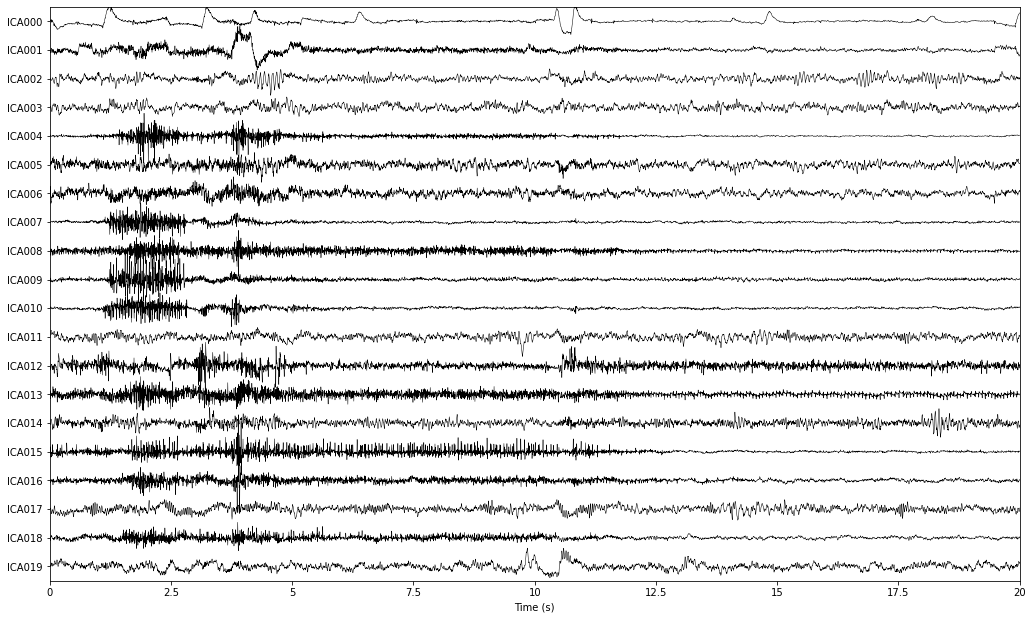

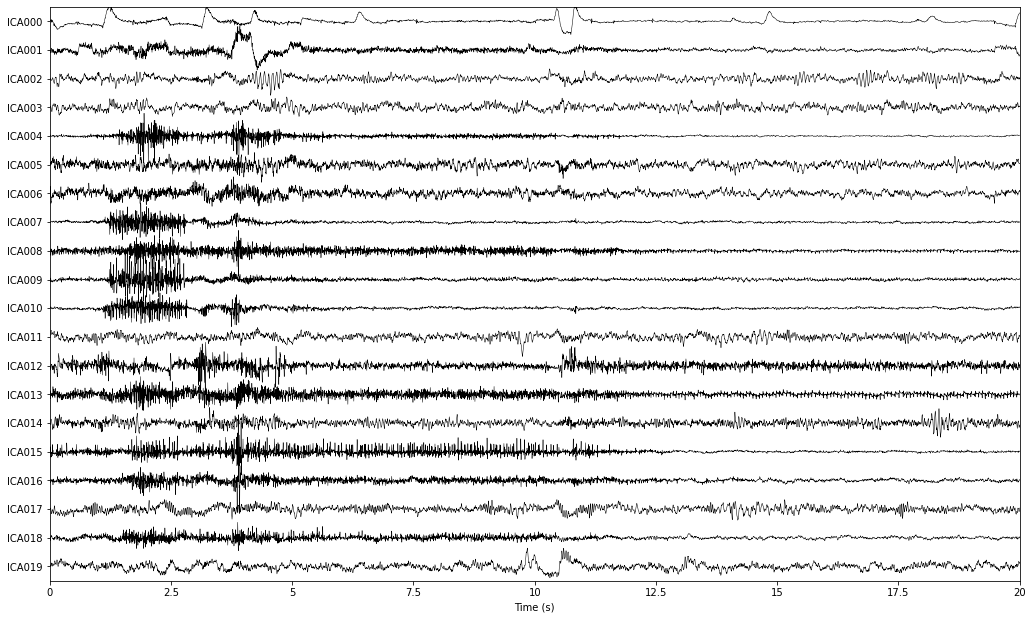

In [12]:
ica.plot_sources(raw, show_scrollbars=True)

Upon inspection, it is clear that components 0-11 are representing some kind of electrical noise. MNE's detect_artifacts function also identified components 36 and 39 as artifact, and this is supported by the ICA time series plots. As for the other components- they may contain artifact, but I cannot be confident that removing them wouldn't also remove critical brain data, so they will remain.

Applying ICA to Raw instance
    Transforming to ICA space (40 components)
    Zeroing out 4 ICA components
    Projecting back using 64 PCA components


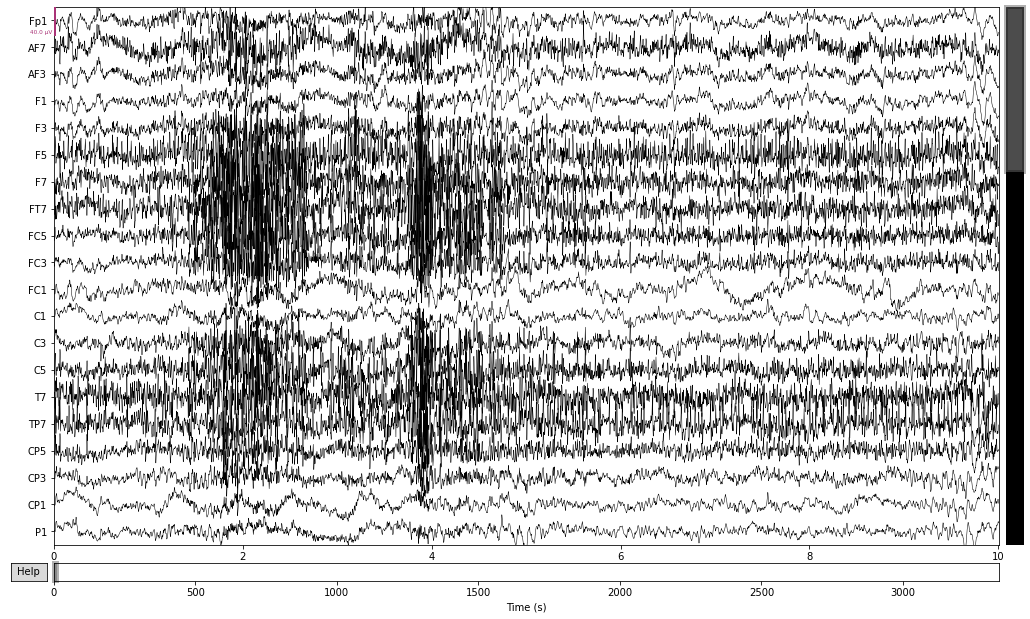

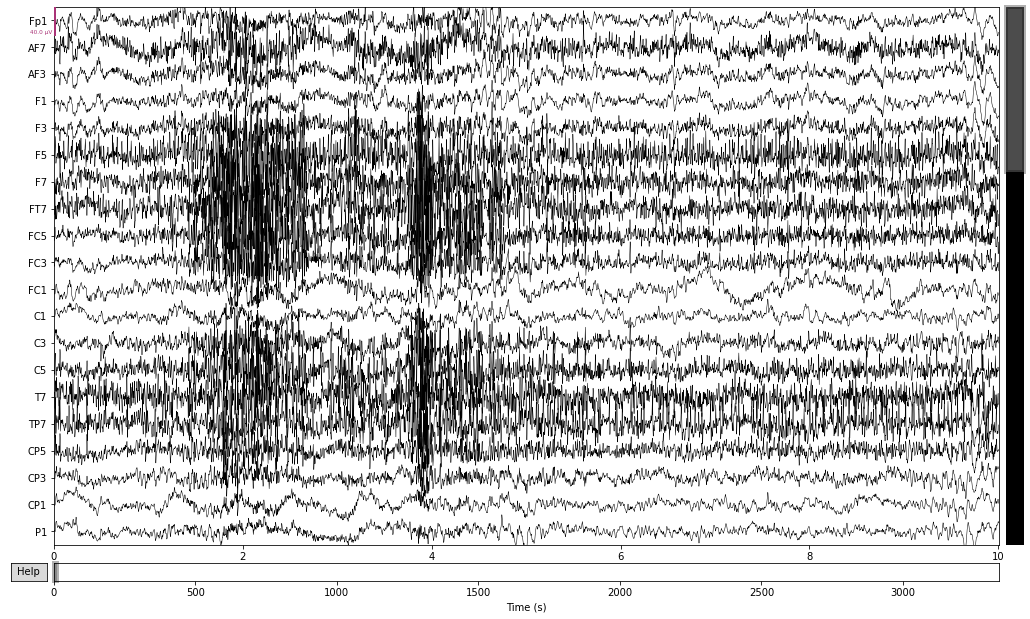

In [14]:
#Remove ICA artifacts and re-plot raw data
ica.apply(raw, exclude= list(range(0,11)))
raw.plot()

The data appear to be much improved by the ICA rejection so we can now save the preprocessed data file.

In [ ]:
raw.save('/Volumes/AMPlab/FR_EEG/preprocessed_EEG/NoDetect_1.fif', overwrite = True)